In [105]:
#Imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Conv2D,MaxPool2D,Dense,Dropout
from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [106]:
# Loading the dataset
mnist_dataset = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist_dataset.load_data()

In [107]:
print(training_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [108]:
#Reshape and Scale

training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

### Model without MC Dropout

In [109]:
def cnn_model(hp):  
  model = keras.Sequential([
    keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [2,3,5]),
        activation='relu',
        input_shape=(28,28,1)
    ),
    MaxPool2D(2,2),
    keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
        kernel_size=hp.Choice('conv_2_kernel', values = [2,3,5]),
        activation='relu'
    ),
    MaxPool2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),
    keras.layers.Dense(10, activation='softmax')
  ])
  
  model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [74]:
# Hyperparameter Tuning

tuner_search=RandomSearch(cnn_model,
                          objective='val_accuracy',
                          max_trials=5,directory='output',project_name="Mnist_Dataset")

tuner_search.search(training_images,training_labels,epochs=3,validation_split=0.1)

Trial 5 Complete [00h 02m 23s]
val_accuracy: 0.9861666560173035

Best val_accuracy So Far: 0.9881666898727417
Total elapsed time: 00h 07m 05s
INFO:tensorflow:Oracle triggered exit


In [75]:
model=tuner_search.get_best_models(num_models=1)[0]
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 800)               0         
                                                                 
 dense (Dense)               (None, 48)                3

In [76]:
model.fit(training_images,training_labels,epochs=10)
model.save("model_withoutMC_mnistTrained.h5")

Epoch 1/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0412 - accuracy: 0.9873
Epoch 2/10
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0313 - accuracy: 0.9900
Epoch 3/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0241 - accuracy: 0.9922
Epoch 4/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0201 - accuracy: 0.9937
Epoch 5/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0157 - accuracy: 0.9949
Epoch 6/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0132 - accuracy: 0.9959
Epoch 7/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0114 - accuracy: 0.9962
Epoch 8/10
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0103 - accuracy: 0.9964
Epoch 9/10
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0092 - accuracy: 0.9967
Epoch 10/10
1875/1875 [==============================] - 16s 8ms/step - l

In [79]:
model.evaluate(test_images,test_labels)

313/313 [==============================] - 1s 2ms/step - loss: 0.0328 - accuracy: 0.9915


[0.032816823571920395, 0.9915000200271606]

### Model with MC Dropout

In [146]:
# Creating model with MC dropput, using hypertuned parameters

def cnn_model_mc():  
  model = Sequential([
    Conv2D(32,(5,5),input_shape=(28,28,1),activation='relu'),
    Dropout(0.4),
    MaxPool2D(2,2),
    Conv2D(32,(3,3),input_shape=(28,28,1),activation='relu'),
    Dropout(0.4),
    MaxPool2D(2,2),
    Flatten(),
    Dense(48, activation='relu'),
    Dropout(0.4),
    Dense(10, activation='softmax')
  ])
  
  model.compile(
  optimizer='Adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
  )
  
  return model

In [112]:
model_mc = cnn_model_mc()
model_mc.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 dropout_3 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 32)        9248      
                                                                 
 dropout_4 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 32)         0         
 2D)                                                  

In [113]:
model_mc.fit(training_images,training_labels,epochs=10)
model_mc.save("model_withMC_mnistTrained.h5")

Epoch 1/10
1875/1875 [==============================] - 24s 12ms/step - loss: 0.2880 - accuracy: 0.9104
Epoch 2/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1271 - accuracy: 0.9620
Epoch 3/10
1875/1875 [==============================] - 23s 13ms/step - loss: 0.1009 - accuracy: 0.9709
Epoch 4/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0857 - accuracy: 0.9744
Epoch 5/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0792 - accuracy: 0.9768
Epoch 6/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0687 - accuracy: 0.9803
Epoch 7/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0678 - accuracy: 0.9802
Epoch 8/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0621 - accuracy: 0.9817
Epoch 9/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.0595 - accuracy: 0.9824
Epoch 10/10
1875/1875 [==============================] - 22s 12m

In [115]:
prediction_stack_mc = np.stack([model_mc(test_images,training=True)
                   for sample in range(100)])

In [125]:
prediction_mean = prediction_stack_mc.mean(axis = 0)
prediction_std = prediction_stack_mc.std(axis = 0)

In [134]:
prediction = np.argmax(prediction_mean , axis = 1)
accuracy = sum(prediction == test_labels) / len(test_labels)

In [135]:
accuracy

0.9924

### Subtask a.

In [93]:
# Removing last layer of my model without MC
model = load_model('model_withoutMC_mnistTrained.h5')
model_without_last_layer = Sequential(model.layers[:-1])

In [94]:
# Getting the model's new outputs
model_outputs = model_without_last_layer.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [95]:
# Compute t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(model_outputs)

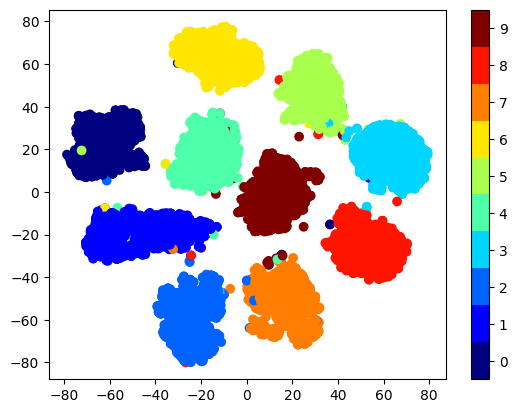

In [96]:
# Plot the t-SNE plot
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=test_labels, cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

### Subtask b.

In [91]:
# Load fashion mnist dataset

mnist_dataset_fashion = tf.keras.datasets.fashion_mnist
(training_images_fashion, training_labels_fashion), (test_images_fashion, test_labels_fashion) = mnist_dataset_fashion.load_data()

4422102/4422102 [==============================] - 3s 1us/step


In [182]:
training_images_fashion=training_images_fashion.reshape(60000, 28, 28, 1)
training_images_fashion=training_images_fashion / 255.0
test_images_fashion = test_images_fashion.reshape(10000, 28, 28, 1)
test_images_fashion=test_images_fashion/255.0

In [149]:
model_mc = cnn_model_mc()

In [150]:
model_mc.fit(training_images_fashion,training_labels_fashion,epochs=10)
model_mc.save("model_withMC_mnistFashionTrained.h5")

Epoch 1/10
1875/1875 [==============================] - 24s 12ms/step - loss: 2.0799 - accuracy: 0.2667
Epoch 2/10
1875/1875 [==============================] - 24s 13ms/step - loss: 1.1189 - accuracy: 0.5836
Epoch 3/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.7722 - accuracy: 0.7086
Epoch 4/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.6723 - accuracy: 0.7401
Epoch 5/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.6116 - accuracy: 0.7635
Epoch 6/10
1875/1875 [==============================] - 25s 13ms/step - loss: 0.5711 - accuracy: 0.7823
Epoch 7/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.5452 - accuracy: 0.7947
Epoch 8/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.5305 - accuracy: 0.8007
Epoch 9/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.5105 - accuracy: 0.8059
Epoch 10/10
1875/1875 [==============================] - 23s 12m

In [158]:
prediction_stack_mc = np.stack([model_mc(test_images_fashion,training=True)
                   for sample in range(100)])

In [159]:
prediction_mean = prediction_stack_mc.mean(axis = 0)
prediction_std = prediction_stack_mc.std(axis = 0)

prediction = np.argmax(prediction_mean , axis = 1)
accuracy = sum(prediction == test_labels_fashion) / len(test_labels_fashion)

In [165]:
print("Accuracy:" , accuracy)

Accuracy: 0.8584


In [ ]:
predictive_entropy = (-prediction_stack_mc * np.log(prediction_stack_mc)).sum(axis=2).mean(axis=0)
predictive_entropy = np.nan_to_num(predictive_entropy, nan=0.0) 

In [168]:
print("The uncertainity for each prediction is stores in the array:" , predictive_entropy)

The uncertainity for each prediction is stores in the array: [0.         0.42987195 0.         ... 0.         0.         0.79346496]


In [169]:
uncertainty = predictive_entropy.std()
print("Uncertainty (standard deviation of predictive entropy):", uncertainty)

Uncertainty (standard deviation of predictive entropy): 0.50088006


#### Subtask c.

In [212]:
# Creating the model without dropout

def cnn_model():  
  model = Sequential([
    Conv2D(32,(5,5),input_shape=(28,28,1),activation='relu'),
    MaxPool2D(2,2),
    Conv2D(32,(3,3),input_shape=(28,28,1),activation='relu'),
    MaxPool2D(2,2),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(20, activation='softmax')
  ])
  
  model.compile(
  optimizer='Adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy']
  )
  
  return model

In [213]:
model = cnn_model()

In [179]:
# Changing the fashion mnist data so that the labels are different from the mnist data

mnist_dataset = tf.keras.datasets.mnist
(training_images, training_labels), (test_images, test_labels) = mnist_dataset.load_data()

mnist_dataset_fashion = tf.keras.datasets.fashion_mnist
(training_images_fashion, training_labels_fashion), (test_images_fashion, test_labels_fashion) = mnist_dataset_fashion.load_data()

In [180]:
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

In [181]:
training_images_fashion=training_images_fashion.reshape(60000, 28, 28, 1)
training_images_fashion=training_images_fashion / 255.0
test_images_fashion = test_images_fashion.reshape(10000, 28, 28, 1)
test_images_fashion=test_images_fashion/255.0

In [202]:
training_labels_fashion_new = []
test_labels_fashion_new = []

for i in range(len(training_labels_fashion)):
    training_labels_fashion_new.append(training_labels_fashion[i] + 10)


for i in range(len(test_labels_fashion)):
    test_labels_fashion_new.append(test_labels_fashion[i] + 10)

In [204]:
training_labels_fashion_new = np.array(training_labels_fashion_new)
test_labels_fashion_new = np.array(test_labels_fashion_new)

In [205]:
combined_training_images = np.concatenate((training_images, training_images_fashion), axis=0)
combined_training_labels = np.concatenate((training_labels, training_labels_fashion_new), axis=0)

In [206]:
combined_test_images = np.concatenate((test_images, test_images_fashion), axis=0)
combined_test_labels = np.concatenate((test_labels, test_labels_fashion_new), axis=0)

In [214]:
model.fit(combined_training_images,combined_training_labels,epochs=10)
model.save("model_withoutMC_mnistTrained_fashionTrained.h5")

Epoch 1/10
3750/3750 [==============================] - 33s 9ms/step - loss: 1.2331 - accuracy: 0.5299
Epoch 2/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.5064 - accuracy: 0.8168
Epoch 3/10
3750/3750 [==============================] - 34s 9ms/step - loss: 0.3441 - accuracy: 0.8714
Epoch 4/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.3062 - accuracy: 0.8858
Epoch 5/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.2758 - accuracy: 0.8987
Epoch 6/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.2530 - accuracy: 0.9071
Epoch 7/10
3750/3750 [==============================] - 31s 8ms/step - loss: 0.2372 - accuracy: 0.9136
Epoch 8/10
3750/3750 [==============================] - 33s 9ms/step - loss: 0.2260 - accuracy: 0.9172
Epoch 9/10
3750/3750 [==============================] - 34s 9ms/step - loss: 0.2157 - accuracy: 0.9211
Epoch 10/10
3750/3750 [==============================] - 33s 9ms/step - l

In [218]:
#Removing the last layer
model_without_last_layer = Sequential(model.layers[:-1])

In [219]:
# Getting the model's outputs
model_outputs = model_without_last_layer.predict(combined_test_images)

625/625 [==============================] - 2s 3ms/step


In [220]:
# Compute t-SNE embeddings
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(model_outputs)

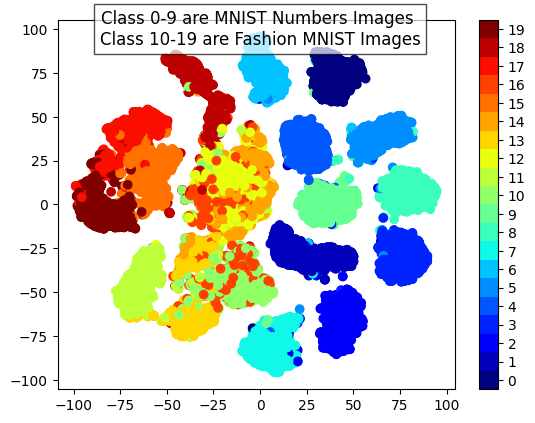

In [226]:
# Plot the t-SNE plot
plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=combined_test_labels, cmap=plt.cm.get_cmap("jet", 20))
plt.colorbar(ticks=range(20))
plt.clim(-0.5, 19.5)
plt.text(0, 100, "Class 0-9 are MNIST Numbers Images \nClass 10-19 are Fashion MNIST Images",
         fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.7))
plt.show()